# A BWR geometry 
This notebook can be used as a template for modeling BWR reactors.

In [25]:
%matplotlib inline
import openmc
import openmc.deplete

import math
import numpy as np
import os

from dotenv import load_dotenv

load_dotenv()

CROSS_SECTIONS = os.getenv('CROSS_SECTIONS')
CHAIN_FILE = os.getenv('CHAIN_FILE')

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

In [26]:
# Materials definitions

uo2 = openmc.Material(name='UO2')
uo2.add_element('U', 1.0, enrichment=1.5)
uo2.add_element('O', 2.0)
uo2.set_density('g/cc', 10.0)

zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

steel = openmc.Material(name='Stainless Steel')
steel.set_density('g/cm3', 8.00)
steel.add_element('C', 0.08, percent_type='wo')
steel.add_element('Si', 1.00, percent_type='wo')
steel.add_element('Mn', 2.00, percent_type='wo')
steel.add_element('P', 0.045, percent_type='wo')
steel.add_element('S', 0.030, percent_type='wo')
steel.add_element('Cr', 20.0, percent_type='wo')
steel.add_element('Ni', 11.0, percent_type='wo')
steel.add_element('Fe', 65.845, percent_type='wo')

water = openmc.Material(name='Water')
water.set_density('g/cm3', 0.76)
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

# 1. Calculate the Volume of One Fuel Pin
fuel_height = 200.0

fuel_pellet_volume = math.pi * (1.0414/2)**2 * fuel_height
gap_volume = math.pi * (1.06426/2)**2 * fuel_height - fuel_pellet_volume
cladding_volume = math.pi * (1.22682/2)**2 * fuel_height - math.pi * (1.06426/2)**2 * fuel_height
fuel_pin_volume = fuel_pellet_volume + gap_volume + cladding_volume

# 2. Calculate the Total UO2 Volume
num_fuel_pins = 64  # Replace with the actual number of fuel pins in your quarter assembly
total_uo2_volume = num_fuel_pins * fuel_pellet_volume  

# 3. Add the Volume to Your UO2 Material
uo2.volume = total_uo2_volume

# Export materials to XML
materials_file = openmc.Materials([uo2, water, zircaloy, steel])
materials_file.export_to_xml()

In [27]:
# Geometry definitions

In [28]:
bottom = openmc.ZPlane(z0=-100.0, boundary_type = 'reflective')
top = openmc.ZPlane(z0=100.0, boundary_type = 'reflective')

In [29]:
pitch = 1.6256

# Create the x and y planes that define the boundaries of the square
x_min = openmc.XPlane(x0=-pitch / 2)
x_max = openmc.XPlane(x0=pitch / 2)
y_min = openmc.YPlane(y0=-pitch / 2)
y_max = openmc.YPlane(y0=pitch / 2)

# Create a region from the intersection of the planes
pin_cell_box = +x_min & -x_max & +y_min & -y_max 

In [30]:
# Geometry definitions for the fuel rod

fuel_or  = openmc.ZCylinder(r=1.0414/2, name='Fuel OR')
fclad_ir = openmc.ZCylinder(r=1.06426/2, name='Clad IR')
fclad_or = openmc.ZCylinder(r=1.22682/2, name='Clad OR')

fuel_region = -fuel_or 
gap_region  = +fuel_or & -fclad_ir
fclad_region  = +fclad_ir & -fclad_or
fwater_region = pin_cell_box & +fclad_or

fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = uo2
fuel_cell.region = fuel_region 

gap_cell = openmc.Cell(name='air gap')
gap_cell.region = gap_region

clad_cell = openmc.Cell(name='clad')
clad_cell.fill = zircaloy
clad_cell.region = fclad_region

fwater_cell = openmc.Cell(name='fwater')
fwater_cell.fill = water
fwater_cell.region = fwater_region

fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

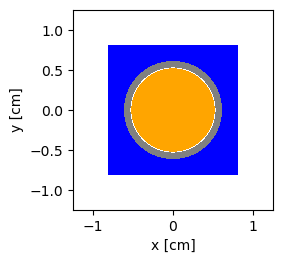

In [31]:
fuel_pin_universe.plot(width=(2.5, 2.5), colors = {fuel_cell: 'orange', gap_cell: 'white', clad_cell: 'grey', fwater_cell: 'blue'})

In [32]:
# Geometry definitions for the water rod

water_or = openmc.ZCylinder(r=1.34874/2)
wclad_or = openmc.ZCylinder(r=1.50114/2)

wwater_inner_region = -water_or
wclad_region = -wclad_or & +water_or 
wwater_outer_region = pin_cell_box & +wclad_or

wwater_inner_cell = openmc.Cell(name='wwater_inner')
wwater_inner_cell.region = wwater_inner_region
wwater_inner_cell.fill = water

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

wwater_outer_cell = openmc.Cell(name='wwater_outer')
wwater_outer_cell.fill = water
wwater_outer_cell.region = wwater_outer_region

water_pin_universe = openmc.Universe(cells=[wwater_inner_cell, wclad_cell, wwater_outer_cell])

In [33]:
# Geometry definitions for the corner rod

corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name = 'Corner Cell: Fuel OR')
corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name = 'Corner Cell: Clad IR')
corner_clad_or = openmc.ZCylinder(r=1.22682/2, name = 'Corner Cell: Clad OR')

corner_fuel_cell = openmc.Cell(name='fuel')
corner_fuel_cell.fill = uo2
corner_fuel_cell.region = -corner_fuel_or 

corner_gap_cell = openmc.Cell(name='air gap')
corner_gap_cell.region = -corner_clad_ir & +corner_fuel_or

corner_clad_cell = openmc.Cell(name='clad')
corner_clad_cell.fill = zircaloy
corner_clad_cell.region = +corner_clad_ir & -corner_clad_or

In [34]:
# Defining an Assembly

In [35]:
margin = 1e-8
sleave_thickness = 0.2032
sleave_inner_radius = 0.9652 + margin

In [36]:
ur_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ur Corner Cell: Fuel OR')
ur_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ur Corner Cell: Clad IR')
ur_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ur Corner Cell: Clad OR')

ur_corner_fuel_cell = openmc.Cell(name='ur fuel')
ur_corner_fuel_cell.fill = uo2
ur_corner_fuel_cell.region = -ur_corner_fuel_or 

ur_corner_gap_cell = openmc.Cell(name='ul air gap')
ur_corner_gap_cell.region = -ur_corner_clad_ir & +ur_corner_fuel_or

ur_corner_clad_cell = openmc.Cell(name='ul clad')
ur_corner_clad_cell.fill = zircaloy
ur_corner_clad_cell.region = +ur_corner_clad_ir & -ur_corner_clad_or

ur_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius)
ur_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius+sleave_thickness)

ur_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
ur_sleave_ver_bound = openmc.YPlane(y0=pitch/2 - sleave_inner_radius + margin)

ur_sleave_cell = openmc.Cell(name='ur sleave cell')
ur_sleave_cell.region = -ur_sleave_or & +ur_sleave_ir & +ur_sleave_hor_bound & +ur_sleave_ver_bound & pin_cell_box
ur_sleave_cell.fill = zircaloy

ur_sleave_water_cell = openmc.Cell(name = 'ur sleave water')
ur_sleave_water_cell.region = pin_cell_box & +ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_or
ur_sleave_water_cell.fill = water

ur_sleave_ver_water_cell = openmc.Cell(name='ur vertically-equivalent sleave water')
ur_sleave_ver_water_cell.region = pin_cell_box & -ur_sleave_hor_bound & +ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_ver_water_cell.fill = water 

ur_opposite_water_cell = openmc.Cell(name='ur opposite water')
ur_opposite_water_cell.region = pin_cell_box & -ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_opposite_water_cell.fill = water 

ur_sleave_hor_water_cell = openmc.Cell(name='ur horizontally-equivalent sleave water')
ur_sleave_hor_water_cell.region = pin_cell_box & +ur_sleave_hor_bound & -ur_sleave_ver_bound & +ur_sleave_ir
ur_sleave_hor_water_cell.fill = water 

ur_inner_water_cell = openmc.Cell(name='ur inner water cell')
ur_inner_water_cell.region = pin_cell_box & -ur_sleave_ir & +ur_corner_clad_or
ur_inner_water_cell.fill = water

ur_corner_pin_universe = openmc.Universe(cells=[ur_corner_fuel_cell, ur_corner_gap_cell, ur_corner_clad_cell, ur_sleave_cell, ur_inner_water_cell, ur_sleave_water_cell, ur_sleave_ver_water_cell, ur_opposite_water_cell, ur_sleave_hor_water_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

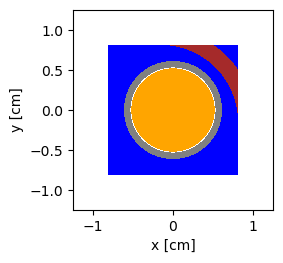

In [37]:
ur_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ur_corner_fuel_cell: 'orange', ur_corner_gap_cell: 'white', ur_corner_clad_cell: 'grey', ur_sleave_cell:'brown', ur_inner_water_cell: 'blue', ur_sleave_water_cell: 'blue', ur_sleave_ver_water_cell: 'blue', ur_opposite_water_cell: 'blue', ur_sleave_hor_water_cell: 'blue'})

In [38]:
ul_corner_fuel_or = openmc.ZCylinder(r=(1.0414/2), name='ul Corner Cell: Fuel OR')
ul_corner_clad_ir = openmc.ZCylinder(r=(1.06426/2), name='ul Corner Cell: Clad IR')
ul_corner_clad_or = openmc.ZCylinder(r=(1.22682/2), name='ul Corner Cell: Clad OR')

ul_corner_fuel_cell = openmc.Cell(name='ul fuel')
ul_corner_fuel_cell.fill = uo2
ul_corner_fuel_cell.region = -ul_corner_fuel_or 

ul_corner_gap_cell = openmc.Cell(name='ul air gap')
ul_corner_gap_cell.region = -ul_corner_clad_ir & +ul_corner_fuel_or

ul_corner_clad_cell = openmc.Cell(name='ul clad')
ul_corner_clad_cell.fill = zircaloy
ul_corner_clad_cell.region = +ul_corner_clad_ir & -ul_corner_clad_or

ul_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius) #Shouldn't have margin
ul_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=pitch/2-sleave_inner_radius+margin, r=sleave_inner_radius + sleave_thickness)

ul_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ul_sleave_ver_bound = openmc.YPlane(y0=pitch/2-sleave_inner_radius+margin)

ul_sleave_cell = openmc.Cell(name='ul sleave cell')
ul_sleave_cell.region = -ul_sleave_or & +ul_sleave_ir & -ul_sleave_hor_bound & +ul_sleave_ver_bound & pin_cell_box
ul_sleave_cell.fill = zircaloy

ul_sleave_water_cell = openmc.Cell(name='ul sleave water')
ul_sleave_water_cell.region = pin_cell_box & -ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_or
ul_sleave_water_cell.fill = water

ul_sleave_ver_water_cell = openmc.Cell(name='ul vertically-equivalent sleave water')
ul_sleave_ver_water_cell.region = pin_cell_box & +ul_sleave_hor_bound & +ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_ver_water_cell.fill = water 

ul_opposite_water_cell = openmc.Cell(name='ul opposite water')
ul_opposite_water_cell.region = pin_cell_box & +ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_opposite_water_cell.fill = water 

ul_sleave_hor_water_cell = openmc.Cell(name='ul horizontally-equivalent sleave water')
ul_sleave_hor_water_cell.region = pin_cell_box & -ul_sleave_hor_bound & -ul_sleave_ver_bound & +ul_sleave_ir
ul_sleave_hor_water_cell.fill = water 

ul_inner_water_cell = openmc.Cell(name='ul inner water cell')
ul_inner_water_cell.region = pin_cell_box & -ul_sleave_ir & +ul_corner_clad_or
ul_inner_water_cell.fill = water

ul_corner_pin_universe = openmc.Universe(cells=[ul_corner_fuel_cell, ul_corner_gap_cell, ul_corner_clad_cell, ul_sleave_cell, ul_inner_water_cell, ul_sleave_water_cell, ul_sleave_ver_water_cell, ul_opposite_water_cell, ul_sleave_hor_water_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

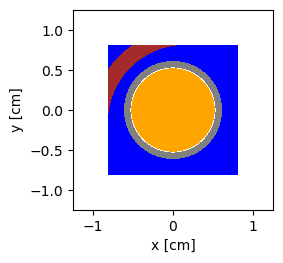

In [39]:
ul_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ul_corner_fuel_cell: 'orange', ul_corner_gap_cell: 'white', ul_corner_clad_cell: 'grey', ul_sleave_cell:'brown', ul_inner_water_cell: 'blue', ul_sleave_water_cell: 'blue', ul_sleave_ver_water_cell: 'blue', ul_opposite_water_cell: 'blue', ul_sleave_hor_water_cell: 'blue'})

In [40]:
ll_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='ll Corner Cell: Fuel OR')
ll_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='ll Corner Cell: Clad IR')
ll_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='ll Corner Cell: Clad OR')

ll_corner_fuel_cell = openmc.Cell(name='ll fuel')
ll_corner_fuel_cell.fill = uo2
ll_corner_fuel_cell.region = -ll_corner_fuel_or 

ll_corner_gap_cell = openmc.Cell(name='ll air gap')
ll_corner_gap_cell.region = -ll_corner_clad_ir & +ll_corner_fuel_or

ll_corner_clad_cell = openmc.Cell(name='ll clad')
ll_corner_clad_cell.fill = zircaloy
ll_corner_clad_cell.region = +ll_corner_clad_ir & -ll_corner_clad_or

ll_sleave_ir = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
ll_sleave_or = openmc.ZCylinder(x0=-pitch/2+sleave_inner_radius+margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

ll_sleave_hor_bound = openmc.XPlane(x0=-pitch/2+sleave_inner_radius+margin)
ll_sleave_ver_bound = openmc.YPlane(y0=-pitch/2+sleave_inner_radius-margin)

ll_sleave_cell = openmc.Cell(name='ul sleave cell')
ll_sleave_cell.region = -ll_sleave_or & +ll_sleave_ir & -ll_sleave_hor_bound & -ll_sleave_ver_bound & pin_cell_box
ll_sleave_cell.fill = zircaloy

ll_sleave_water_cell = openmc.Cell(name='ul sleave water')
ll_sleave_water_cell.region = pin_cell_box & -ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_or
ll_sleave_water_cell.fill = water

ll_sleave_ver_water_cell = openmc.Cell(name='ul vertically-equivalent sleave water')
ll_sleave_ver_water_cell.region = pin_cell_box & +ll_sleave_hor_bound & -ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_ver_water_cell.fill = water 

ll_opposite_water_cell = openmc.Cell(name='ul opposite water')
ll_opposite_water_cell.region = pin_cell_box & +ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_opposite_water_cell.fill = water 

ll_sleave_hor_water_cell = openmc.Cell(name='ul horizontally-equivalent sleave water')
ll_sleave_hor_water_cell.region = pin_cell_box & -ll_sleave_hor_bound & +ll_sleave_ver_bound & +ll_sleave_ir
ll_sleave_hor_water_cell.fill = water 

ll_inner_water_cell = openmc.Cell(name='ul inner water cell')
ll_inner_water_cell.region = pin_cell_box & -ll_sleave_ir & +ll_corner_clad_or
ll_inner_water_cell.fill = water

ll_corner_pin_universe = openmc.Universe(cells=[ll_corner_fuel_cell, ll_corner_gap_cell, ll_corner_clad_cell, ll_sleave_cell, ll_inner_water_cell, ll_sleave_water_cell, ll_sleave_ver_water_cell, ll_opposite_water_cell, ll_sleave_hor_water_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

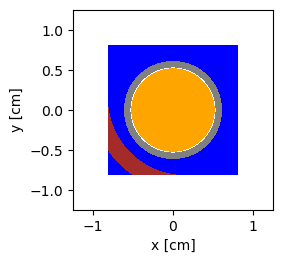

In [41]:
ll_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {ll_corner_fuel_cell: 'orange', ll_corner_gap_cell: 'white', ll_corner_clad_cell: 'grey', ll_sleave_cell:'brown', ll_inner_water_cell: 'blue', ll_sleave_water_cell: 'blue', ll_sleave_ver_water_cell: 'blue', ll_opposite_water_cell: 'blue', ll_sleave_hor_water_cell: 'blue'})

In [42]:
lr_corner_fuel_or = openmc.ZCylinder(r=1.0414/2, name='lr Corner Cell: Fuel OR')
lr_corner_clad_ir = openmc.ZCylinder(r=1.06426/2, name='lr Corner Cell: Clad IR')
lr_corner_clad_or = openmc.ZCylinder(r=1.22682/2, name='lr Corner Cell: Clad OR')

lr_corner_fuel_cell = openmc.Cell(name='lr fuel')
lr_corner_fuel_cell.fill = uo2
lr_corner_fuel_cell.region = -lr_corner_fuel_or 

lr_corner_gap_cell = openmc.Cell(name='lr air gap')
lr_corner_gap_cell.region = -lr_corner_clad_ir & +lr_corner_fuel_or

lr_corner_clad_cell = openmc.Cell(name='lr clad')
lr_corner_clad_cell.fill = zircaloy
lr_corner_clad_cell.region = +lr_corner_clad_ir & -lr_corner_clad_or

lr_sleave_ir = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius)
lr_sleave_or = openmc.ZCylinder(x0=pitch/2-sleave_inner_radius-margin, y0=-pitch/2+sleave_inner_radius-margin, r=sleave_inner_radius+sleave_thickness)

lr_sleave_hor_bound = openmc.XPlane(x0=pitch/2 - sleave_inner_radius - margin)
lr_sleave_ver_bound = openmc.YPlane(y0=-pitch/2 + sleave_inner_radius - margin)

lr_sleave_cell = openmc.Cell(name='ur sleave cell')
lr_sleave_cell.region = -lr_sleave_or & +lr_sleave_ir & +lr_sleave_hor_bound & -lr_sleave_ver_bound & pin_cell_box
lr_sleave_cell.fill = zircaloy

lr_sleave_water_cell = openmc.Cell(name='ur sleave water')
lr_sleave_water_cell.region = pin_cell_box & +lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_or
lr_sleave_water_cell.fill = water

lr_sleave_ver_water_cell = openmc.Cell(name='ur vertically-equivalent sleave water')
lr_sleave_ver_water_cell.region = pin_cell_box & -lr_sleave_hor_bound & -lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_ver_water_cell.fill = water 

lr_opposite_water_cell = openmc.Cell(name='ur opposite water')
lr_opposite_water_cell.region = pin_cell_box & -lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_opposite_water_cell.fill = water 

lr_sleave_hor_water_cell = openmc.Cell(name='ur horizontally-equivalent sleave water')
lr_sleave_hor_water_cell.region = pin_cell_box & +lr_sleave_hor_bound & +lr_sleave_ver_bound & +lr_sleave_ir
lr_sleave_hor_water_cell.fill = water 

lr_inner_water_cell = openmc.Cell(name='ur inner water cell')
lr_inner_water_cell.region = pin_cell_box & -lr_sleave_ir & +lr_corner_clad_or
lr_inner_water_cell.fill = water

lr_corner_pin_universe = openmc.Universe(cells=[lr_corner_fuel_cell, lr_corner_gap_cell, lr_corner_clad_cell, lr_sleave_cell, lr_inner_water_cell, lr_sleave_water_cell, lr_sleave_ver_water_cell, lr_opposite_water_cell, lr_sleave_hor_water_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

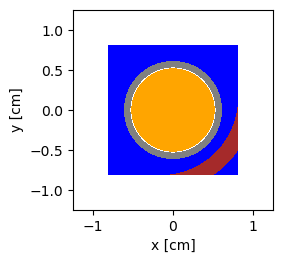

In [43]:
lr_corner_pin_universe.plot(width=(2.5, 2.5), basis = 'xy', colors = {lr_corner_fuel_cell: 'orange', lr_corner_gap_cell: 'white', lr_corner_clad_cell: 'grey', lr_sleave_cell:'brown', lr_inner_water_cell: 'blue', lr_sleave_water_cell: 'blue', lr_sleave_ver_water_cell: 'blue', lr_opposite_water_cell: 'blue', lr_sleave_hor_water_cell: 'blue'})

In [44]:
import openmc

# ... (previous code defining pitch, universes, etc.) ...

quarter_pitch = pitch * 8

assembly = openmc.RectLattice(name='Quarter Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-quarter_pitch/2, -quarter_pitch/2]

assembly.universes = [
                      [ul_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, ur_corner_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, water_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, water_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe],
                      [ll_corner_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, fuel_pin_universe, lr_corner_pin_universe]
]

# Define x and y planes for assembly region
x_min_assembly = openmc.XPlane(x0=-quarter_pitch / 2)
x_max_assembly = openmc.XPlane(x0=quarter_pitch / 2)
y_min_assembly = openmc.YPlane(y0=-quarter_pitch / 2)
y_max_assembly = openmc.YPlane(y0=quarter_pitch / 2)

# Create assembly region using planes
assembly_region = +x_min_assembly & -x_max_assembly & +y_min_assembly & -y_max_assembly
assembly_cell = openmc.Cell(name='quarter assembly cell', fill=assembly, region=assembly_region)

# Define x and y planes for assembly sleeve with added thickness
x_min_sleave = openmc.XPlane(x0=-(quarter_pitch + 2*sleave_thickness) / 2)
x_max_sleave = openmc.XPlane(x0=(quarter_pitch + 2*sleave_thickness) / 2)
y_min_sleave = openmc.YPlane(y0=-(quarter_pitch + 2*sleave_thickness) / 2)
y_max_sleave = openmc.YPlane(y0=(quarter_pitch + 2*sleave_thickness) / 2)

# Create assembly sleeve region using planes and exclude assembly region
assembly_sleave = openmc.Cell(name='quarter assembly sleave')
assembly_sleave.region = +x_min_sleave & -x_max_sleave & +y_min_sleave & -y_max_sleave & ~assembly_cell.region 
assembly_sleave.fill = zircaloy

# Define x and y planes for outer water with added thickness and reflective boundary
x_min_water = openmc.XPlane(x0=-(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
x_max_water = openmc.XPlane(x0=(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
y_min_water = openmc.YPlane(y0=-(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')
y_max_water = openmc.YPlane(y0=(quarter_pitch + 2*sleave_thickness + 1) / 2, boundary_type='reflective')

# Create outer water region using planes and exclude assembly and sleeve regions
assembly_outer_water = openmc.Cell(name='assembly outer water')
assembly_outer_water.region = +x_min_water & -x_max_water & +y_min_water & -y_max_water & ~assembly_sleave.region & ~assembly_cell.region
assembly_outer_water.fill = water

quarter_assembly_universe = openmc.Universe(cells=[assembly_cell, assembly_sleave, assembly_outer_water])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

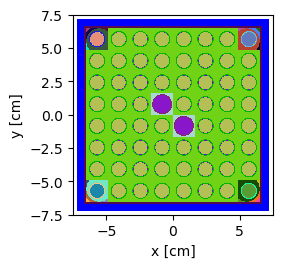

In [45]:
quarter_assembly_universe.plot(width=(15,15), colors={assembly_outer_water: 'blue'})

In [46]:
geom = openmc.Geometry(quarter_assembly_universe)
geom.export_to_xml()

In [47]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.IndependentSource(space=point)  # Use IndependentSource
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 200
settings.export_to_xml()

In [48]:
# --- Flux Spectrum Tally ---
energy_bins = np.logspace(-3, 7, 100)  # Example energy bins (adjust as needed)
flux_tally = openmc.Tally(name='flux_spectrum')
flux_tally.filters = [openmc.EnergyFilter(energy_bins)]
flux_tally.scores = ['flux']

# --- Reaction Rate Tally ---
reaction_rate_tally = openmc.Tally(name='reaction_rates')
reaction_rate_tally.scores = ['fission', 'absorption', '(n,gamma)']  # Add more reactions if needed

# --- Add Tallies to a Tallies File ---
tallies_file = openmc.Tallies()
tallies_file.append(flux_tally)
tallies_file.append(reaction_rate_tally)
tallies_file.export_to_xml()

In [49]:
# Specify the reactor power in Watts (adjust to a realistic value)
power = 2e9  

# Create an OpenMC model
model = openmc.Model()
model.geometry = geom
model.materials = materials_file
model.settings = settings
model.tallies = tallies_file

# Create the depletion operator
operator = openmc.deplete.CoupledOperator(model=model)

# Define time steps (adjust as needed)
time_steps = [30 * 24 * 60 * 60] * 20  # 20 steps of 30 days each

# Choose an integrator and run the depletion
integrator = openmc.deplete.CECMIntegrator(operator, time_steps, power)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Na23 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Na23.
 h5
 Reading Mg24 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mg24.
 h5
 Reading Mg25 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mg25.
 h5
 Reading Mg26 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mg26.
 h5
 Reading Al26_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Al26_
 m1.h5
 Reading Al27 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Al27.
 h5
 Reading Si31 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Si31.
 h5
 Reading Si32 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Si32.
 h5
 Reading S35 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/S35.h
 5
 Reading Cl35 from
 /home/maskedmatters/Documents/C

 Reading Ar38 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ar38.
 h5
 Reading Ar39 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ar39.
 h5
 Reading Ar40 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ar40.
 h5
 Reading Ar41 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ar41.
 h5
 Reading K39 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/K39.h
 5
 Reading K40 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/K40.h
 5
 Reading K41 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/K41.h
 5
 Reading Ca40 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ca40.
 h5
 Reading Ca41 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ca41.
 h5
 Reading Ca42 from
 /home/maskedmatters/Documents/Code/TPR/li

 Reading Se82 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Se82.
 h5
 Reading Br79 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Br79.
 h5
 Reading Br80 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Br80.
 h5
 Reading Br81 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Br81.
 h5
 Reading Kr78 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Kr78.
 h5
 Reading Kr79 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Kr79.
 h5
 Reading Kr80 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Kr80.
 h5
 Reading Kr81 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Kr81.
 h5
 Reading Kr82 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Kr82.
 h5
 Reading Kr83 from
 /home/maskedmatters/Documents/Code/

 Reading Nb93 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Nb93.
 h5
 Reading Nb94 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Nb94.
 h5
 Reading Nb95 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Nb95.
 h5


 Reading Mo92 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo92.
 h5
 Reading Mo93 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo93.
 h5
 Reading Mo94 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo94.
 h5
 Reading Mo95 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo95.
 h5
 Reading Mo96 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo96.
 h5
 Reading Mo97 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo97.
 h5
 Reading Mo98 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo98.
 h5
 Reading Mo99 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo99.
 h5
 Reading Mo100 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Mo100
 .h5
 Reading Tc98 from
 /home/maskedmatters/Documents/Cod

 Reading Tc99 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Tc99.
 h5
 Reading Ru96 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru96.
 h5
 Reading Ru97 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru97.
 h5
 Reading Ru98 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru98.
 h5
 Reading Ru99 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru99.
 h5
 Reading Ru100 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru100
 .h5
 Reading Ru101 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru101
 .h5
 Reading Ru102 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru102
 .h5
 Reading Ru103 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ru103
 .h5
 Reading Ru104 from
 /home/maskedmatters/Docume

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd106 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd106
 .h5
 Reading Cd107 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd107
 .h5
 Reading Cd108 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd108
 .h5
 Reading Cd109 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd109
 .h5
 Reading Cd110 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd110
 .h5
 Reading Cd111 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd111
 .h5
 Reading Cd112 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd112
 .h5
 Reading Cd113 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd113
 .h5
 Reading Cd114 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cd114
 .h5
 Reading Cd115_m1 from
 /home/maskedm

          1200K
          2500K


 Reading Sn126 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sn126
 .h5
 Reading Sb121 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb121
 .h5
 Reading Sb122 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb122
 .h5
 Reading Sb123 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb123
 .h5
 Reading Sb124 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb124
 .h5
 Reading Sb125 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb125
 .h5
 Reading Sb126 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Sb126
 .h5
 Reading Te120 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te120
 .h5
 Reading Te121 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te121
 .h5


          1200K
          2500K


 Reading Te121_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te121
 _m1.h5
 Reading Te122 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te122
 .h5
 Reading Te123 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te123
 .h5
 Reading Te124 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te124
 .h5
 Reading Te125 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te125
 .h5
 Reading Te126 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te126
 .h5
 Reading Te127_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te127
 _m1.h5
 Reading Te128 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te128
 .h5
 Reading Te129_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Te129
 _m1.h5
 Reading Te130 from

 Reading I132_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/I132_
 m1.h5
 Reading I133 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/I133.
 h5
 Reading I134 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/I134.
 h5
 Reading I135 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/I135.
 h5
 Reading Xe123 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe123
 .h5
 Reading Xe124 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe124
 .h5
 Reading Xe125 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe125
 .h5
 Reading Xe126 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe126
 .h5
 Reading Xe127 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe127
 .h5
 Reading Xe128 from
 /home/maskedmatter

          2500K


 Reading Xe136 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Xe136
 .h5
 Reading Cs133 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cs133
 .h5
 Reading Cs134 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cs134
 .h5
 Reading Cs135 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cs135
 .h5
 Reading Cs136 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cs136
 .h5
 Reading Cs137 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cs137
 .h5
 Reading Ba130 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba130
 .h5
 Reading Ba131 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba131
 .h5


          1200K
          2500K


 Reading Ba132 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba132
 .h5
 Reading Ba133 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba133
 .h5
 Reading Ba134 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba134
 .h5
 Reading Ba135 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba135
 .h5
 Reading Ba136 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba136
 .h5
 Reading Ba137 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba137
 .h5
 Reading Ba138 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba138
 .h5
 Reading Ba139 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba139
 .h5
 Reading Ba140 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ba140
 .h5
 Reading La138 from
 /home/maskedmatt

          1200K
          2500K


 Reading Gd152 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd152
 .h5
 Reading Gd153 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd153
 .h5
 Reading Gd154 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd154
 .h5
 Reading Gd155 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd155
 .h5
 Reading Gd156 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd156
 .h5
 Reading Gd157 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd157
 .h5
 Reading Gd158 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd158
 .h5
 Reading Gd159 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd159
 .h5
 Reading Gd160 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Gd160
 .h5
 Reading Tb158 from
 /home/maskedmatt

          1200K
          2500K


 Reading Yb170 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb170
 .h5
 Reading Yb171 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb171
 .h5
 Reading Yb172 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb172
 .h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb173 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb173
 .h5
 Reading Yb174 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb174
 .h5
 Reading Yb175 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb175
 .h5
 Reading Yb176 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Yb176
 .h5
 Reading Lu175 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Lu175
 .h5
 Reading Lu176 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Lu176
 .h5
 Reading Hf174 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf174
 .h5


          1200K
          2500K


 Reading Hf175 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf175
 .h5
 Reading Hf176 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf176
 .h5
 Reading Hf177 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf177
 .h5
 Reading Hf178 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf178
 .h5
 Reading Hf179 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf179
 .h5
 Reading Hf180 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf180
 .h5
 Reading Hf181 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf181
 .h5
 Reading Hf182 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Hf182
 .h5
 Reading Ta180 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ta180
 .h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta181 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ta181
 .h5
 Reading Ta182 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Ta182
 .h5
 Reading W180 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W180.
 h5
 Reading W181 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W181.
 h5
 Reading W182 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W182.
 h5
 Reading W183 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W183.
 h5
 Reading W184 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W184.
 h5
 Reading W185 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W185.
 h5
 Reading W186 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/W186.
 h5
 Reading Re185 from
 /home/maskedmatters/Documents/

          1200K


 Reading Cf251 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cf251
 .h5
 Reading Cf252 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cf252
 .h5
 Reading Cf253 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cf253
 .h5
 Reading Cf254 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Cf254
 .h5
 Reading Es251 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Es251
 .h5
 Reading Es252 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Es252
 .h5
 Reading Es253 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Es253
 .h5
 Reading Es254 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Es254
 .h5
 Reading Es254_m1 from
 /home/maskedmatters/Documents/Code/TPR/libraries/endfb-viii.0-hdf5/neutron/Es254
 _m1.h5
 Reading Es255 from
 /home/mask

: 